## Spec3Pipeline for MRS   (MIRI MRS CALSPEC3)

`Spec3Pipeline` combines the calibrated data from multiple exposures (e.g. a dither/nod pattern) into a single combined 3D spectral product and a combined 1D spectrum. Before being combined, the exposures receive additional corrections for the purpose of background matching and subtraction, as well as outlier rejection.

Official documentation for `Spec3Pipeline` can be found here:

<https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec3.html>

The `Spec3Pipeline` for MRS comprises a linear series of steps. The steps in order are:

|Step|Description|
|:---|:---|
|`master_background`|subtract master background spectrum created from input exposures or supplied by user|
|`mrs_imatch`|matches image intensities of input MIRI MRS images|
|`outlier_detection`|flag any remaining cosmic-rays or other artifacts left over from previous calibrations|
|`cube_build`|produce 3D spectral cubes from the 'cleaned' 2D detector image|
|`extract_1d`|extract 1D spectrum from 3D cube|


For more information and examples of each of the steps click on the links in the side bar. 

Note that the `master_background` step is not yet part of the `pec3Pipeline` so will not be run in this version. When it is included it will only be run if there was no dedidcated background exposure subtraction by the `background` step in `Spec2Pipeline`.

Users of this notebook should be aware that cubes and spectra produce will not be perfect and suffer from known issues with MIRISim (oversized MRS PSF, channel 4 flux issues, etc.) and the calibration pipeline (aperture correction factors, overly simplistic spectral extraction). 

### Input data

An example of running the file through the `Spec3Pipeline` is now shown using a simple simulated fullband, 2-point dither observation of a point source (power law plus emission lines spectrum) with the MIRI MRS produced with [MIRISim v2.1](http://miri.ster.kuleuven.be/bin/view/Public/MIRISimPublicRelease2dot1) and brought to level 2B using the `Detector1Pipeline` and `Spec2Pipeline`. 

### Python

Start by importing what will be used and set the `CRDS_CONTEXT`

In [1]:
# imports
import os, glob, shutil
import numpy as np
from matplotlib.colors import LogNorm
from cycler import cycler
import matplotlib.pyplot as plt
from subprocess import call
from jwst import datamodels
from jwst.associations.lib.member import Member
from jwst.associations.asn_from_list import asn_from_list

# set the CRDS_CONTEXT
os.environ["CRDS_CONTEXT"] = "jwst_0535.pmap"

`Image3Pipeline` requires an association file as input that lists the exposures to be combined. The content of the association file is printed for inspection. It is assumed they are in 'MRS_science'.

In [2]:
# load the science and background files to lists
my_science_files = glob.glob('MRS_science/*photom.fits')
my_science_files = sorted(my_science_files)

# set the association name
asn_name = 'my_point_source'

# setup an empty level 2 association structure
asn = asn_from_list(my_science_files, product_name=asn_name)

# set some metadata
asn['asn_pool'] = asn_name + '_pool'
asn['asn_type'] = 'spec3'
        
# print the association and save to file
name, ser = asn.dump()
print(ser)

asn_file = asn_name + '_lvl3_asn.json'
with open(asn_file, 'w') as f:
    f.write(ser)

{
    "asn_type": "spec3",
    "asn_rule": "DMS_Level3_Base",
    "version_id": null,
    "code_version": "0.13.7",
    "degraded_status": "No known degraded exposures in association.",
    "program": "noprogram",
    "constraints": "No constraints",
    "asn_id": "a3001",
    "target": "none",
    "asn_pool": "my_point_source_pool",
    "products": [
        {
            "name": "my_point_source",
            "members": [
                {
                    "expname": "MRS_science/my_point_source_exposure10_photom.fits",
                    "exptype": "science"
                },
                {
                    "expname": "MRS_science/my_point_source_exposure11_photom.fits",
                    "exptype": "science"
                },
                {
                    "expname": "MRS_science/my_point_source_exposure12_photom.fits",
                    "exptype": "science"
                },
                {
                    "expname": "MRS_science/my_point_source_expos

Import `Spec3Pipeline` and print the docstring to show some information

In [3]:
from jwst.pipeline import Spec3Pipeline
print(Spec3Pipeline.__doc__)


    Spec3Pipeline: Processes JWST spectroscopic exposures from Level 2b to 3.

    Included steps are:
    MIRI MRS background matching (skymatch)
    outlier detection (outlier_detection)
    2-D spectroscopic resampling (resample_spec)
    3-D spectroscopic resampling (cube_build)
    1-D spectral extraction (extract_1d)
    


The association file is passed as input. The output files will be saved in `my_output_dir`. 

*Parameters used:*
    
`save_results`: boolean, optional, default=False  
&nbsp;&nbsp;&nbsp;&nbsp; save the results to file
    
`output_dir` : boolean, optional, default is the working directory   
&nbsp;&nbsp;&nbsp;&nbsp; the location to save the output

`steps` : dict, optional, default None  
&nbsp;&nbsp;&nbsp;&nbsp; pass parameters to steps

The `skip` parameters is passed to `outlier_detection` (due to a bug causing the pipeline to crash) and `skymatch` (which at the moment appears to be overestimating the background resulting in negative fluxes) and we explictly save the `cube_build` and `extract_1d` output using the `save_results` parameter.


In [4]:
# user specified
my_output_dir = 'demo_output'

# the output directory should be created if it doesn't exist
if not os.path.exists(my_output_dir): 
    os.mkdir(my_output_dir)

# run the pipeline
Spec3Pipeline.call(asn_file, save_results=True, output_dir=my_output_dir, 
                   steps={'outlier_detection': {'skip': True},
                          'mrs_imatch': {'skip': True},
                          'cube_build': {'save_results': True},
                          'extract_1d': {'save_results': True}})


2019-08-21 11:53:52,512 - stpipe.Spec3Pipeline - INFO - Spec3Pipeline instance created.
2019-08-21 11:53:52,514 - stpipe.Spec3Pipeline.master_background - INFO - MasterBackgroundStep instance created.
2019-08-21 11:53:52,517 - stpipe.Spec3Pipeline.mrs_imatch - INFO - MRSIMatchStep instance created.
2019-08-21 11:53:52,521 - stpipe.Spec3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2019-08-21 11:53:52,524 - stpipe.Spec3Pipeline.resample_spec - INFO - ResampleSpecStep instance created.
2019-08-21 11:53:52,527 - stpipe.Spec3Pipeline.cube_build - INFO - CubeBuildStep instance created.
2019-08-21 11:53:52,529 - stpipe.Spec3Pipeline.extract_1d - INFO - Extract1dStep instance created.
2019-08-21 11:53:52,530 - stpipe.Spec3Pipeline.combine_1d - INFO - Combine1dStep instance created.
2019-08-21 11:53:52,603 - stpipe.Spec3Pipeline - INFO - Step Spec3Pipeline running with args ('my_point_source_lvl3_asn.json',).
2019-08-21 11:54:34,677 - stpipe.Spec3Pipeline - INFO - 

2019-08-21 11:54:39,078 - stpipe.Spec3Pipeline - INFO - Prefetching reference files for dataset: 'my_point_source_exposure6_photom.fits' reftypes = ['cubepar', 'drizpars', 'extract1d', 'resol']
2019-08-21 11:54:39,083 - stpipe.Spec3Pipeline - INFO - Prefetch for CUBEPAR reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_cubepar_0002.fits'.
2019-08-21 11:54:39,084 - stpipe.Spec3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_drizpars_0001.fits'.
2019-08-21 11:54:39,085 - stpipe.Spec3Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_extract1d_0003.json'.
2019-08-21 11:54:39,086 - stpipe.Spec3Pipeline - INFO - Prefetch for RESOL reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_resol_0003.fits'.
2019-08-21 11:54:39,087 - stpipe.Spec3Pipeline - INFO - Prefetching referenc

2019-08-21 11:56:44,148 - stpipe.Spec3Pipeline.cube_build - INFO - Number of bands in cube: 1
2019-08-21 11:56:45,467 - stpipe.Spec3Pipeline.cube_build - INFO - Cube Geometry:
2019-08-21 11:56:45,468 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)
2019-08-21 11:56:45,468 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 1    48  25.00  -0.00001337   0.13000000  -3.18499988   3.18499988
2019-08-21 11:56:45,470 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 2    36  19.00  -0.00005723   0.13000000  -2.40499991   2.40499991
2019-08-21 11:56:45,470 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)
2019-08-21 11:56:45,471 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 3   990   1.00   5.64999996   0.00100000   5.64999996   6.64000000
2019-08-21 11:56:45,471 - stpipe.Spec3Pipeline.cube_build - INFO - Cube covers channel, subchannel: 1, medium 
2019-08-21 11:56

2019-08-21 12:01:40,448 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 3   861   1.00   9.98899986   0.00200000   9.98899986  11.71099995
2019-08-21 12:01:40,449 - stpipe.Spec3Pipeline.cube_build - INFO - Cube covers channel, subchannel: 2, long 
2019-08-21 12:01:40,449 - stpipe.Spec3Pipeline.cube_build - INFO - Output Name: my_point_source_ch2-long_s3d.fits
2019-08-21 12:01:41,318 - stpipe.Spec3Pipeline.cube_build - INFO - Time to transform pixels to output frame = 0.9.s
2019-08-21 12:02:15,698 - stpipe.Spec3Pipeline.cube_build - INFO - Time to match file to ifucube = 34.4.s
2019-08-21 12:02:16,331 - stpipe.Spec3Pipeline.cube_build - INFO - Time to transform pixels to output frame = 0.6.s
2019-08-21 12:02:50,089 - stpipe.Spec3Pipeline.cube_build - INFO - Time to match file to ifucube = 33.8.s
2019-08-21 12:02:50,105 - stpipe.Spec3Pipeline.cube_build - INFO - Time to find Cube Flux = 0.0.s
2019-08-21 12:02:51,260 - stpipe.Spec3Pipeline.cube_build - INFO - IFUChannel 2
2019-08-21 12:02

2019-08-21 12:07:55,094 - stpipe.Spec3Pipeline.cube_build - INFO - Time to find Cube Flux = 0.0.s
2019-08-21 12:07:56,698 - stpipe.Spec3Pipeline.cube_build - INFO - IFUChannel 4
2019-08-21 12:07:56,766 - stpipe.Spec3Pipeline.cube_build - INFO - Increasing spatial region of interest default value set for 4 dithers 0.600000
2019-08-21 12:07:56,767 - stpipe.Spec3Pipeline.cube_build - INFO - Number of bands in cube: 1
2019-08-21 12:07:57,911 - stpipe.Spec3Pipeline.cube_build - INFO - Cube Geometry:
2019-08-21 12:07:57,912 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)
2019-08-21 12:07:57,912 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 1    34  18.00   0.00008614   0.34999999  -6.12499990   6.12499990
2019-08-21 12:07:57,913 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 2    26  14.00  -0.00016877   0.34999999  -4.72499992   4.72499992
2019-08-21 12:07:57,914 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis

2019-08-21 12:10:22,833 - stpipe.Spec3Pipeline.extract_1d - INFO - source_type = extended
2019-08-21 12:10:24,013 - stpipe.Spec3Pipeline.extract_1d - WARNING - Using cdelt1 = 2.757e+04 arcsec for both dimensions of a pixel
2019-08-21 12:10:24,064 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_extract1d_0003.json
2019-08-21 12:10:24,090 - stpipe.Spec3Pipeline.extract_1d - INFO - source_type = extended
2019-08-21 12:10:25,492 - stpipe.Spec3Pipeline.extract_1d - WARNING - Using cdelt1 = 2.757e+04 arcsec for both dimensions of a pixel
2019-08-21 12:10:25,531 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_extract1d_0003.json
2019-08-21 12:10:25,556 - stpipe.Spec3Pipeline.extract_1d - INFO - source_type = extended
2019-08-21 12:10:27,296 - stpipe.Spec3Pipeline.extract_1d - WARNING - Using cdelt1 = 2.757e+04 a

We can plot the before (rate) and after (cal) images for the first dither position of the SHORT band

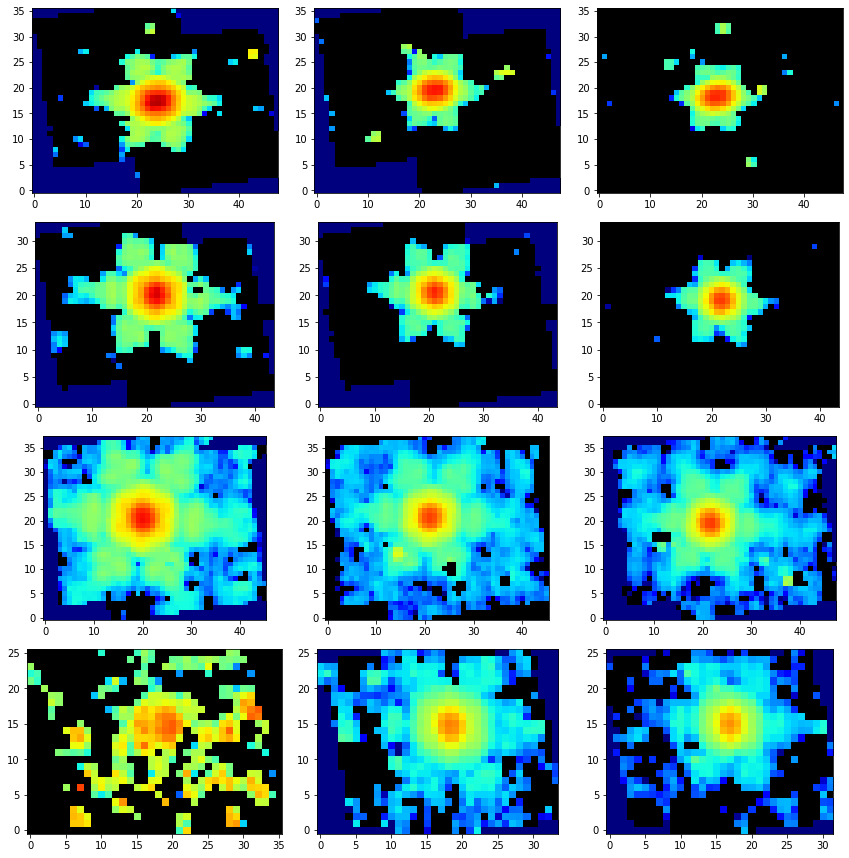

In [5]:
cube_files = glob.glob(os.path.join(my_output_dir, '*s3d.fits'))
cube_files = sorted(cube_files)

fig, axs = plt.subplots(4, 3, figsize=(12, 12))
axs = axs.ravel()

for n, c in enumerate(cube_files):
    cdm = datamodels.open(c)
    axs[n].imshow(np.sum(cdm.data[100:-100], axis=0), cmap='jet', interpolation='nearest', 
                  origin='lower', norm=LogNorm(vmin=1,vmax=1e6))
    axs[n].set_facecolor('black')
    
plt.tight_layout()
plt.show()

Since we have set the source type to 'POINT' above, the extract_1d step will use an aperture extraction and subtract a background with default values. The aperture centre is at pixel x/2, y/2, the radius is y/4, and the background annulus is from the radius to the radius*sqrt(2). In the future, more advanced extraction methods are planned. One can set also the aperture properties using a custom aperture reference file. Please contact pkavanagh@cp.dias.ie if you want to do this.

The extracted spectra are in units of mJy/arcsec^2. To convert these to mJy we multiply by the spaxel area. Note that an additional aperture correction factor for the encircled energy in the aperture should also be applied but we forego this here since the CDPs are currently not available.

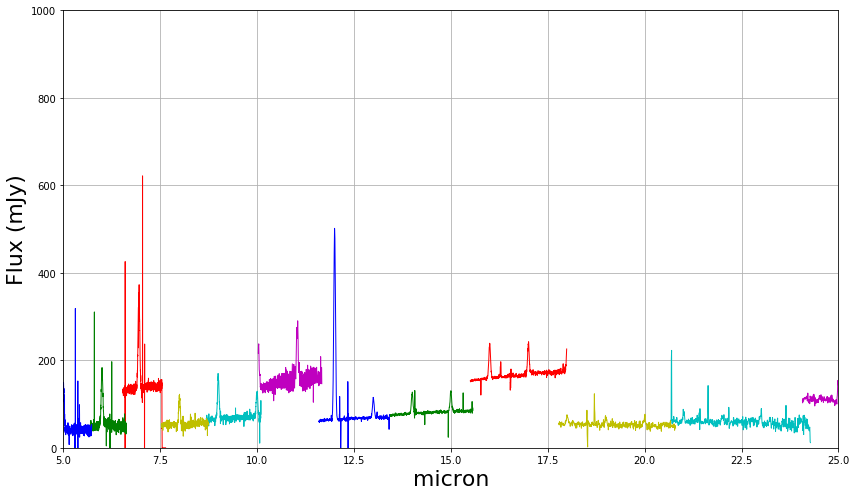

In [12]:
spec_files = glob.glob(os.path.join(my_output_dir, '*1d.fits'))
spec_files = sorted(spec_files)

fig, axs = plt.subplots(1, 1, figsize=(12, 7))
plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'm', 'c', 'y'])))

for n, s in enumerate(spec_files):
    sdm = datamodels.open(s)
    axs.plot(sdm.spec[0].spec_table['WAVELENGTH'][20:-20],
                sdm.spec[0].spec_table['SURF_BRIGHT'][20:-20], marker='.', markersize=0,
                linestyle='-', linewidth=1)

axs.set_ylabel(r'Flux (mJy)', fontsize=22)
axs.set_ylim(0, 1e3)
axs.set_xlim(5, 25)

axs.set_xlabel('micron', fontsize=22)
axs.grid()

plt.tight_layout()
plt.show()

### Command line

To achieve the same result from the command line there are a couple of options. However, one must still generate the association file. In this case, it is best to copy the template above into a text file and save it to `my_point_source_lvl3_asn.json`. The content is printed here for convenience.

```python
{
    "asn_type": "spec3",
    "asn_rule": "DMS_Level3_Base",
    "version_id": null,
    "code_version": "0.13.7",
    "degraded_status": "No known degraded exposures in association.",
    "program": "noprogram",
    "constraints": "No constraints",
    "asn_id": "a3001",
    "target": "none",
    "asn_pool": "my_point_source_pool",
    "products": [
        {
            "name": "my_point_source",
            "members": [
                {
                    "expname": "MRS_science/my_point_source_exposure10_photom.fits",
                    "exptype": "science"
                },
                {
                    "expname": "MRS_science/my_point_source_exposure11_photom.fits",
                    "exptype": "science"
                },
                {
                    "expname": "MRS_science/my_point_source_exposure12_photom.fits",
                    "exptype": "science"
                },
                {
                    "expname": "MRS_science/my_point_source_exposure1_photom.fits",
                    "exptype": "science"
                },
                {
                    "expname": "MRS_science/my_point_source_exposure2_photom.fits",
                    "exptype": "science"
                },
                {
                    "expname": "MRS_science/my_point_source_exposure3_photom.fits",
                    "exptype": "science"
                },
                {
                    "expname": "MRS_science/my_point_source_exposure4_photom.fits",
                    "exptype": "science"
                },
                {
                    "expname": "MRS_science/my_point_source_exposure5_photom.fits",
                    "exptype": "science"
                },
                {
                    "expname": "MRS_science/my_point_source_exposure6_photom.fits",
                    "exptype": "science"
                },
                {
                    "expname": "MRS_science/my_point_source_exposure7_photom.fits",
                    "exptype": "science"
                },
                {
                    "expname": "MRS_science/my_point_source_exposure8_photom.fits",
                    "exptype": "science"
                },
                {
                    "expname": "MRS_science/my_point_source_exposure9_photom.fits",
                    "exptype": "science"
                }
            ]
        }
    ]
}
```

**Option 1:**
Run the `Spec3Pipeline` class using the `strun` command:

```bash
mkdir demo_output

strun jwst.pipeline.Spec3Pipeline my_point_source_lvl3_asn.json --output_dir demo_output --steps.outlier_detection.skip True --steps.mrs_imatch.skip True --steps.cube_build.save_results True --steps.extract_1d.save_results True
```

This will produce the same output file in the user-defined `--output_dir`


**Option 2:**
Collect the pipeline configuration files in your working directory (if they are not already there) using `collect_pipeline_configs` and then run the `Spec3Pipeline` using the `strun` command with the associated `calwebb_spec3.cfg` file. This option is a little more flexible as one can create edit the cfg files, use them again, etc.

```bash
mkdir demo_output

collect_pipeline_cfgs cfgs/

strun cfgs/calwebb_spec3.cfg my_point_source_lvl3_asn.json --output_dir demo_output --steps.outlier_detection.skip True --steps.mrs_imatch.skip True --steps.cube_build.save_results True --steps.extract_1d.save_results True 
```

This will produce the same output file in the user-defined `--output_dir`

## Further examples

Other notebooks with more complex examples can be found here:

*To be added*